# Trabalho de monografia para conclusão do curso de engenharia financeira - PecePoli

O presente trabalho procura estabelecer através de uma abordagem empírica um modelo de série temporal para a previsão de um ativo conhecido no mercado.
Utilizando aprendizado de maquina com a ferramenta Python e como série histórica o Biticoin em dolar americano ("BTC-USD").
A partir da análise da série histórica de dados, gerou-se um modelo de série temporal capaz de prever o preço do ativo para um futuro próximo.
Gerado um modelo ARIMA e penalizando-o por erro médio quadrático e comparando com o modelo gerado pela biblioteca Python aberta do Facebook Prophet, podendo assim determinar qual dos modelos gerou resultado com menor erro médio quarático.

In [554]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib as mlt
import nbconvert
%matplotlib inline

In [555]:
btc = web.DataReader(["BTC-USD"],'yahoo' , '2010' ,'2020') # Final de 2020 a 2021 - Erro em D, fill = 0

In [556]:
btc.index.freq = "D"
btc.index
btc.dropna()
btc.columns

MultiIndex([('Adj Close', 'BTC-USD'),
            (    'Close', 'BTC-USD'),
            (     'High', 'BTC-USD'),
            (      'Low', 'BTC-USD'),
            (     'Open', 'BTC-USD'),
            (   'Volume', 'BTC-USD')],
           names=['Attributes', 'Symbols'])

In [557]:
btc.head(10)

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2014-09-17,457.334015,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,398.821014,412.425995,393.181000,408.084991,26580100
2014-09-22,402.152008,402.152008,406.915985,397.130005,399.100006,24127600
2014-09-23,435.790985,435.790985,441.557007,396.196991,402.092010,45099500
2014-09-24,423.204987,423.204987,436.112000,421.131989,435.751007,30627700


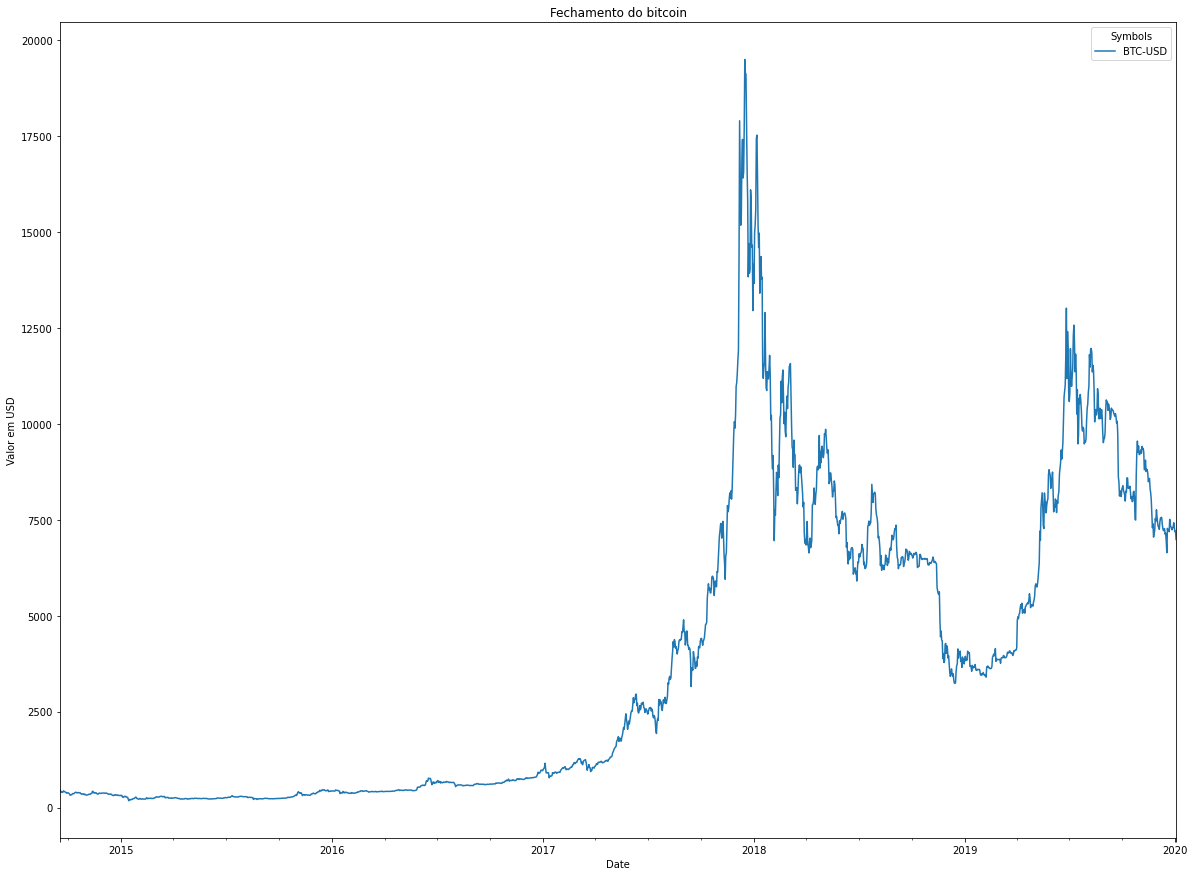

In [558]:
series = btc["Adj Close"]
series.plot(figsize = (20,15), legend = True, title = "Fechamento do bitcoin",ylabel = "Valor em USD")
series.dropna
plt.savefig(f'Variação do preço do Bitcoin.png')

# Separação


In [559]:
train_sample = len(series) - 50
test_sample  = 50
Samples = {"Série menos 50": train_sample , "50 dias de teste" : test_sample}
Samples

{'Série menos 50': 1884, '50 dias de teste': 50}

In [560]:
train = series[:train_sample]
teste = series[train_sample:]
print(len(train), len(series), len(teste))
train.dropna
print(train['BTC-USD'][1883])
print(train.tail(10))
teste.head(10)

1884 1934 50
8808.2626953125
Symbols         BTC-USD
Date                   
2019-11-04  9412.612305
2019-11-05  9342.527344
2019-11-06  9360.879883
2019-11-07  9267.561523
2019-11-08  8804.880859
2019-11-09  8813.582031
2019-11-10  9055.526367
2019-11-11  8757.788086
2019-11-12  8815.662109
2019-11-13  8808.262695


Symbols,BTC-USD
Date,
2019-11-14,8708.094727
2019-11-15,8491.992188
2019-11-16,8550.760742
2019-11-17,8577.975586
2019-11-18,8309.286133
2019-11-19,8206.145508
2019-11-20,8027.268066
2019-11-21,7642.750000
2019-11-22,7296.577637


## Teste de Dickey fuller ampliado


In [561]:
from statsmodels.tsa.stattools import adfuller

In [562]:
def adf_test(serie):
    resultado = adfuller(serie.dropna() , autolag = "AIC") 
    saida = pd.Series(resultado[0:4] , index = ['ADF teste' , 'Valor de p' , 'lags' , 'Observações'])
    
    if resultado[1] <= 0.05:
        print(f'Não possui raiz unitária, grande evidencia de ser estacionária')
    else:
        print(f'Possui raiz unitária, forte evidencia de não ser estácionária')
    
    return saida
# Esse é o teste de estacionariedade da série

In [563]:
adf_test(train)

Possui raiz unitária, forte evidencia de não ser estácionária


ADF teste        -1.678261
Valor de p        0.442346
lags             20.000000
Observações    1863.000000
dtype: float64

In [564]:
from statsmodels.tsa.statespace.tools import diff

In [565]:
train_diff = diff(train)
adf_test(train_diff)

Não possui raiz unitária, grande evidencia de ser estacionária


ADF teste     -8.422788e+00
Valor de p     1.962960e-13
lags           1.900000e+01
Observações    1.863000e+03
dtype: float64

<AxesSubplot:xlabel='Date'>

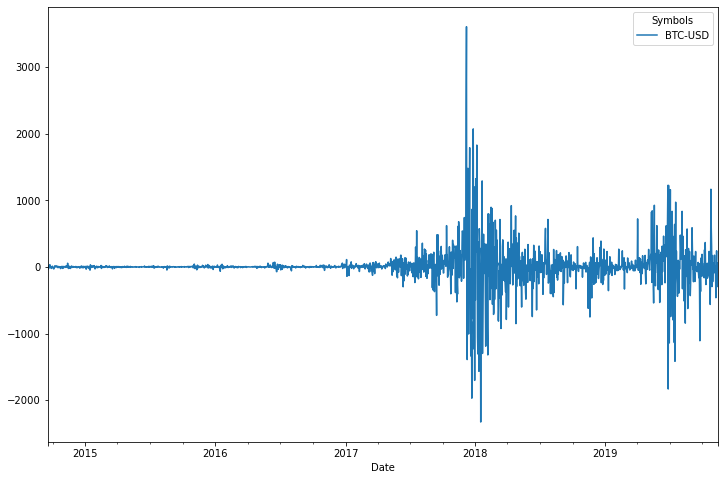

In [566]:
train_diff.plot(figsize = (12,8))

## Mostrou possuir raiz unitária 


## Vamos descobrir o modelo

In [567]:
from pmdarima import auto_arima

In [568]:
Gera_auto = auto_arima(train, seasonal= True, trace=True , stepwise=False)
Gera_auto.summary()


 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=26577.703, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=26576.239, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=26576.257, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=26577.766, Time=0.26 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=26571.898, Time=0.32 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=26558.447, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=26576.448, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=26568.444, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=26570.012, Time=0.97 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=26571.177, Time=0.76 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=26564.265, Time=0.77 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=26576.604, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=26569.992, Time=0.84 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=26572.073, Time=1.45 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=26543.363, Time=2.95

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1884
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -13264.682
Date:                Sat, 12 Feb 2022   AIC                          26543.363
Time:                        09:56:01   BIC                          26582.148
Sample:                             0   HQIC                         26557.648
                               - 1884                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.5936     24.193      0.190      0.849     -42.825      52.012
ar.L1         -1.6168      0.024    -66.242      0.000      -1.665      -1.569
ar.L2         -0.8711      0.022    -39.957      0.000      -0.914      -0.828
ma.L1          1.6800      0.025     67.297      0.000       1.631       1.729
ma.L2          0.9419      0.027     35.384      0.000       0.890       0.994
ma.L3          0.0590      0.009      6.746      0.000       0.042       0.076
sigma2      7.691e+04    731.883    105.087      0.000    7.55e+04    7.83e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             60558.70
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             744.81   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [569]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Resultado FIT

In [570]:
model = ARIMA(train, order=(2,1,3))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                BTC-USD   No. Observations:                 1884
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -13264.790
Date:                Sat, 12 Feb 2022   AIC                          26541.580
Time:                        09:56:03   BIC                          26574.824
Sample:                    09-17-2014   HQIC                         26553.824
                         - 11-13-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6183      0.024    -66.865      0.000      -1.666      -1.571
ar.L2         -0.8716      0.022    -40.200      0.000      -0.914      -0.829
ma.L1          1.6818      0.025     68.198      0.0

C:\Users\rapha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


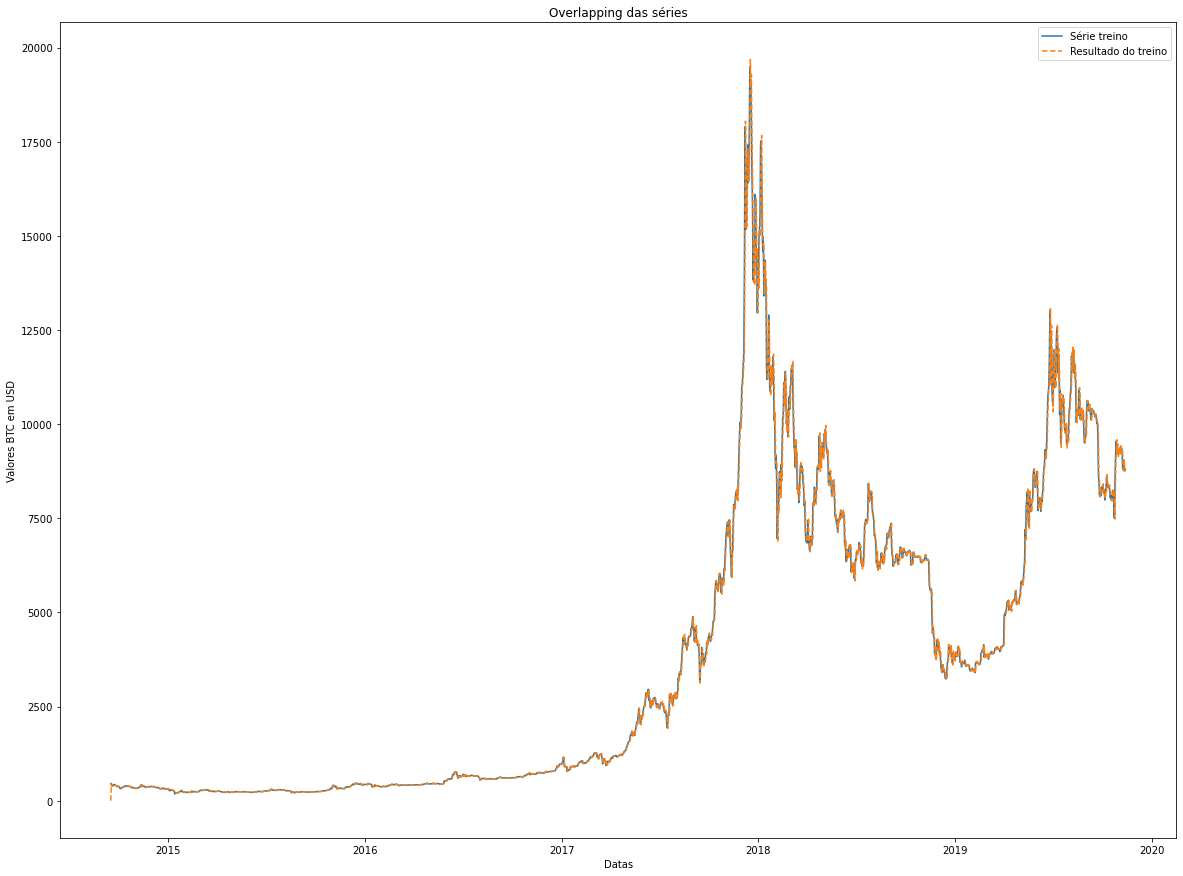

In [571]:
resultado_fit = model_fit.predict()

plt.figure(2, figsize=(20,15))
plt.title('Overlapping das séries')
plt.ylabel('Valores BTC em USD')
plt.xlabel('Datas')
plt.plot(train, label='Série treino')
plt.plot(resultado_fit, linestyle='--', label='Resultado do treino')
plt.legend()
plt.savefig(f'Overlapping das séries')

# RMSE

In [572]:
from statsmodels.tools.eval_measures import rmse

In [573]:
train = series[:train_sample]
erro = rmse(train['BTC-USD'], resultado_fit)
erro

277.5424061126119

In [574]:
train['BTC-USD'].mean()

3669.145614591627

# Fazer passos a frente e o crossvalidation

In [575]:
forecast = model_fit.forecast(steps=5)
forecast 
print(forecast)
erro = rmse(forecast, teste['BTC-USD'][0:5])
erro

2019-11-14    8786.901356
2019-11-15    8817.160662
2019-11-16    8785.906356
2019-11-17    8810.111761
2019-11-18    8798.181175
Freq: D, Name: predicted_mean, dtype: float64


303.36250526827064

In [576]:
teste['BTC-USD'][0:5].mean()

8527.621875

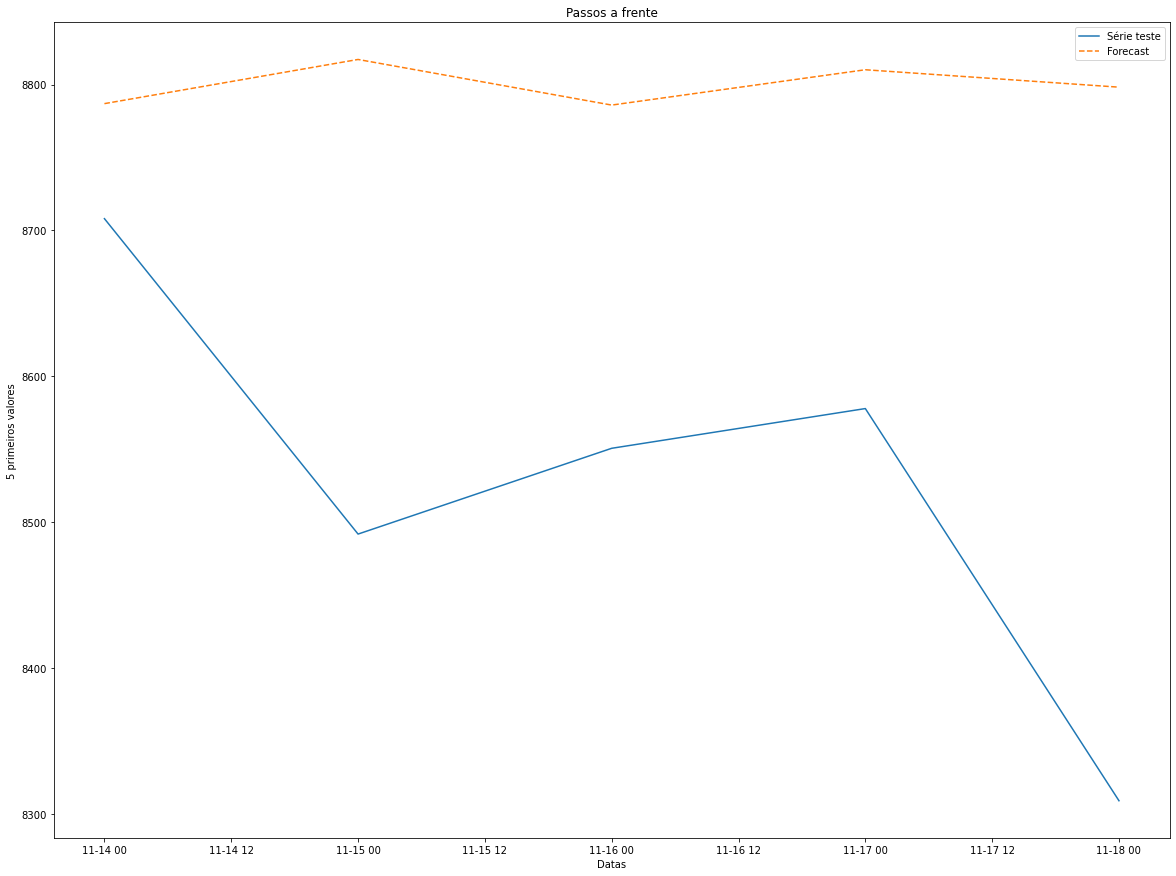

In [577]:
plt.figure(2, figsize=(20,15))
plt.title('Passos a frente')
plt.ylabel('5 primeiros valores')
plt.xlabel('Datas')
plt.plot(teste[0:5], label='Série teste')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.legend()
plt.savefig('Cinco passos a frente')

# Crossvalidation

In [578]:
CV = series[:train_sample + 50]
CV.head()

Symbols,BTC-USD
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [579]:

newdict = {}

for i in range(0 , len(teste)+1):
    
    CV_ARIMA = ARIMA(CV[:1884+i], order=(2,1,3))
    modelCV = CV_ARIMA.fit()
    CV_forecast  = modelCV.forecast(steps=1)
    for key, var in CV_forecast.items():
        newdict[key] = var
        

C:\Users\rapha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rapha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rapha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rapha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rapha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

In [580]:
CV = pd.DataFrame.from_dict(newdict, orient='index',
                       columns=['Cross'])
len(CV)

51

In [581]:
CV['Série'] = teste["BTC-USD"][0:50]

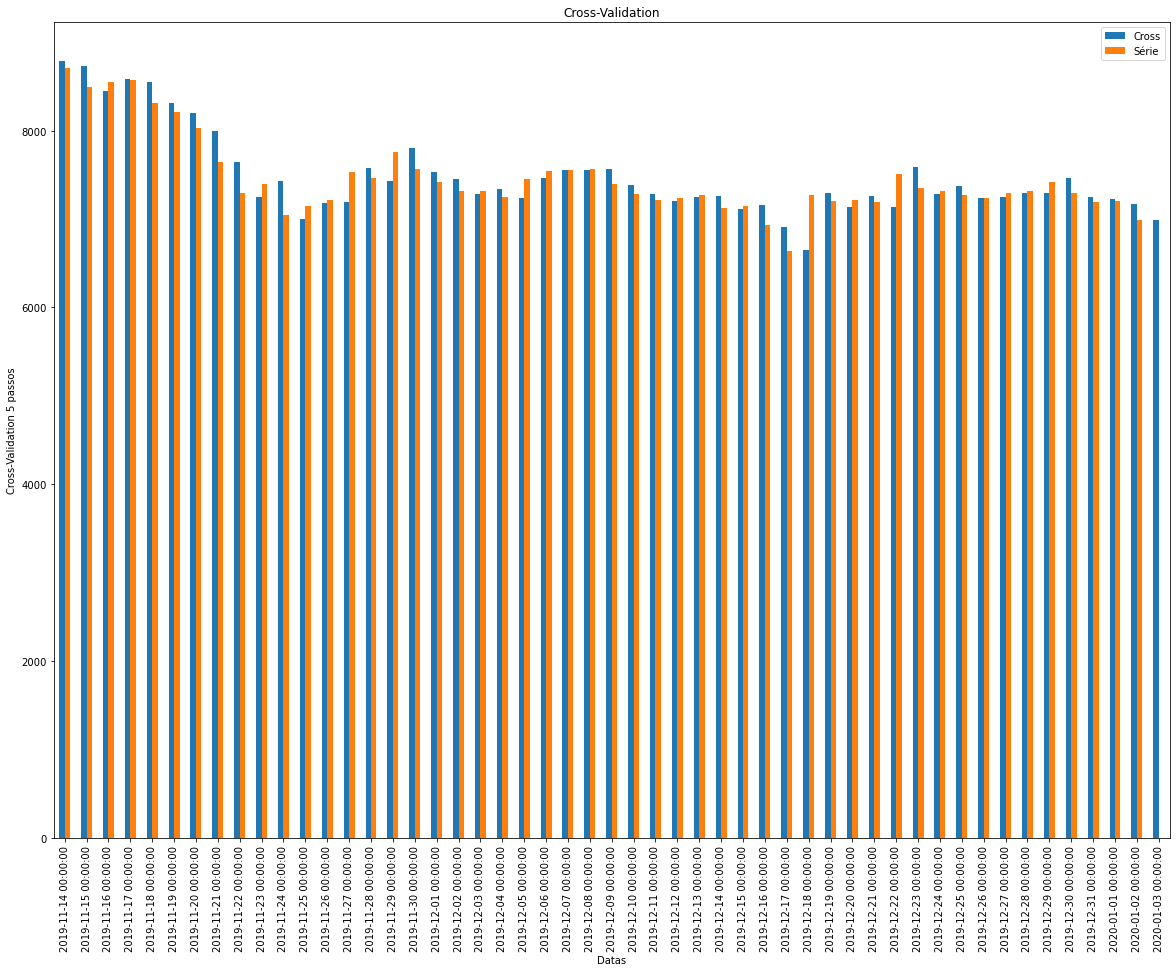

In [582]:
CV.plot(kind='bar', figsize=(20,15), title='Cross-Validation',ylabel='Cross-Validation 5 passos', xlabel='Datas')
plt.savefig(f'Cross-validation.png')

In [583]:
CV['Erro'] = abs(CV['Cross'] - CV['Série'])

In [584]:
CV

,Cross,Série,Erro
2019-11-14,8786.901356,8708.094727,78.806629
2019-11-15,8733.350504,8491.992188,241.358316
2019-11-16,8448.004114,8550.760742,102.756628
2019-11-17,8584.729461,8577.975586,6.753875
2019-11-18,8554.012420,8309.286133,244.726288
2019-11-19,8308.625134,8206.145508,102.479627
2019-11-20,8204.080351,8027.268066,176.812285
2019-11-21,7998.521280,7642.750000,355.771280
2019-11-22,7649.945093,7296.577637,353.367456
2019-11-23,7251.277228,7397.796875,146.519647


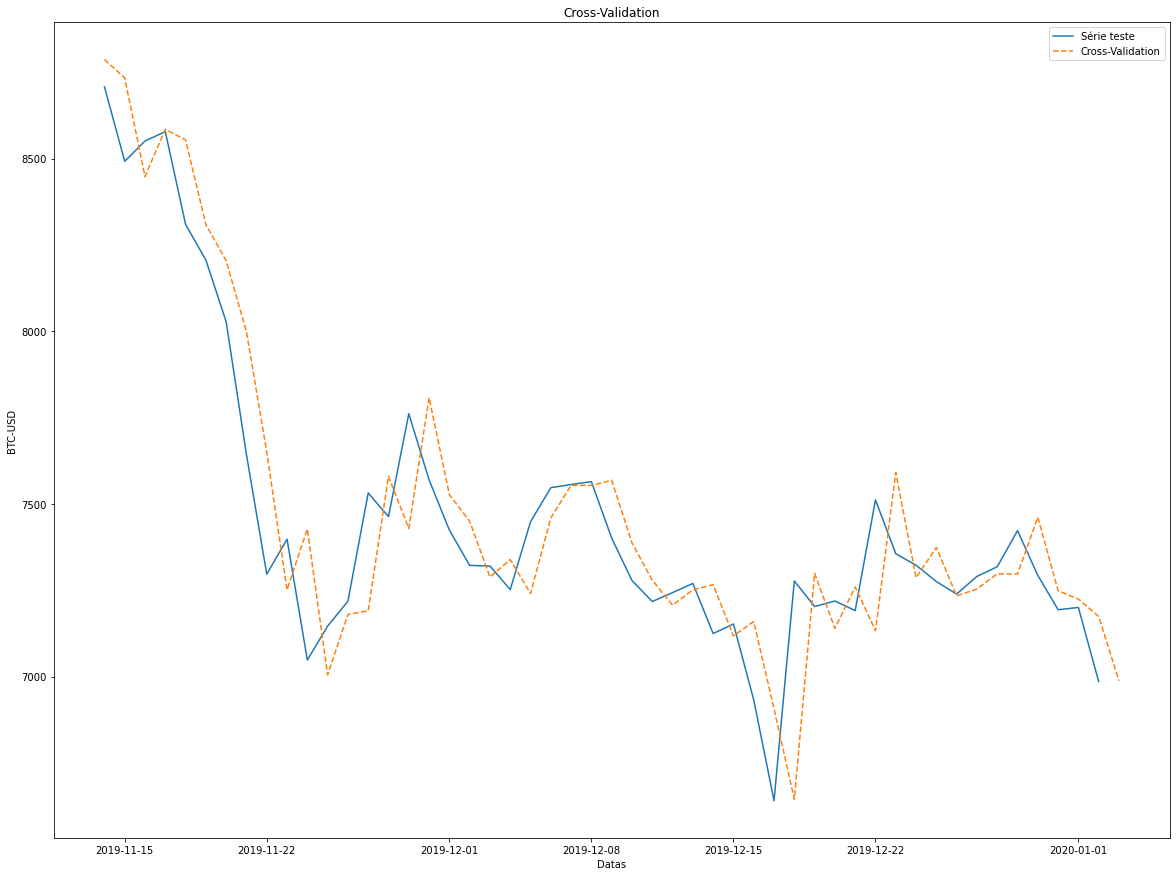

In [585]:
plt.figure(2, figsize=(20,15))
plt.title('Cross-Validation')
plt.ylabel('BTC-USD')
plt.xlabel('Datas')
plt.plot(CV['Série'], label='Série teste')
plt.plot(CV['Cross'], label='Cross-Validation', linestyle='--')
plt.legend()
plt.savefig('Cross-Validation')

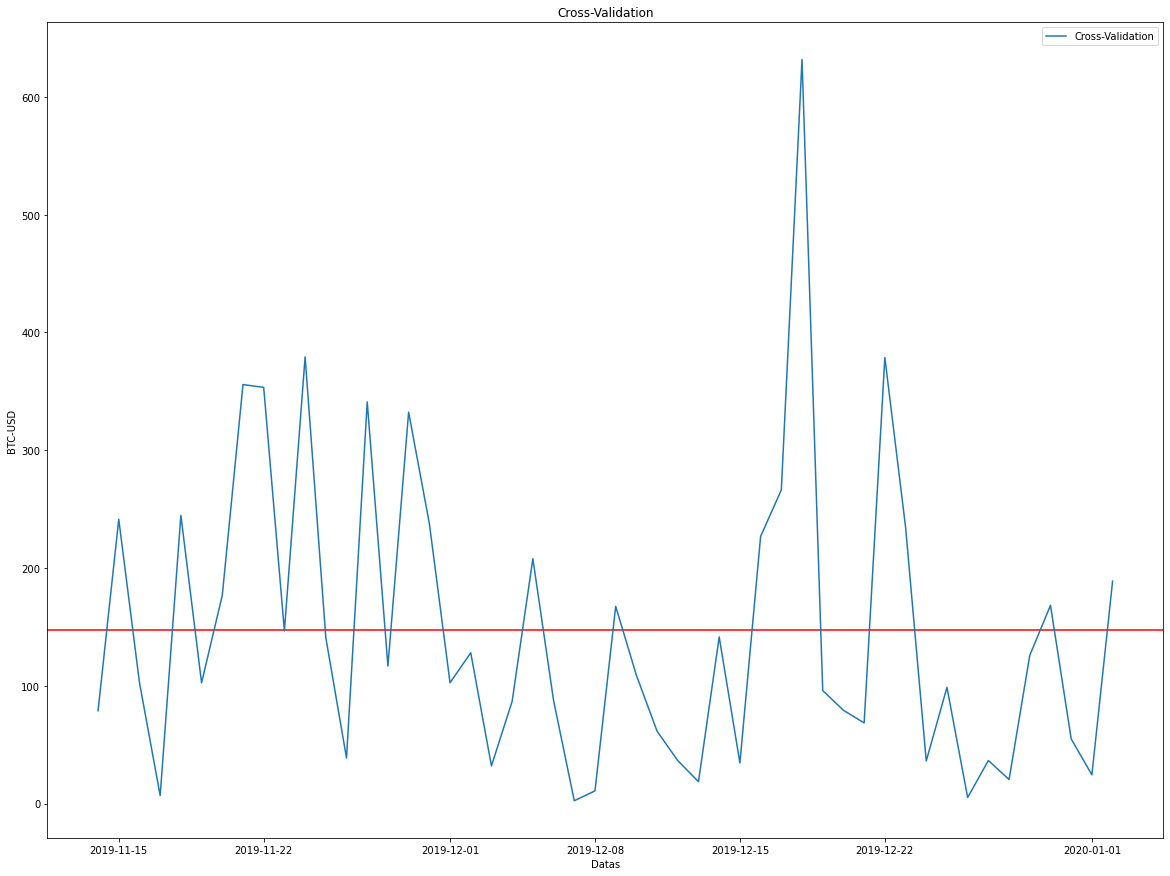

In [586]:
plt.figure(2, figsize=(20,15))
plt.title('Cross-Validation')
plt.ylabel('BTC-USD')
plt.xlabel('Datas')
plt.axhline(CV['Erro'].mean(), color='red')
plt.plot(CV['Erro'], label='Cross-Validation')
plt.legend()
plt.savefig('Cross-Validation - RMSE')

In [587]:
CV['Erro'].mean()

147.26466246309022

In [625]:
RMSE = rmse(CV['Cross'][:50], CV['Série'][0:50])

In [627]:
round(RMSE, 4)

195.0007

In [588]:
teste['BTC-USD'][0:50].mean()

7458.735224609375

# Prophet

In [589]:
btc_prophet = btc.drop(columns=[('Adj Close', 'BTC-USD'),           
            (     'High', 'BTC-USD'),
            (      'Low', 'BTC-USD'),
            (     'Open', 'BTC-USD'),
            (   'Volume', 'BTC-USD')])

btc_prophet['ds'] = btc_prophet.index
btc_prophet['y']  = btc_prophet.Close
btc_prophet = btc_prophet.drop(columns=([('Close','BTC-USD')]))
btc_prophet.reset_index(drop= True , inplace= True)
btc_prophet.head()

Attributes,ds,y
Symbols,,
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [590]:
train = len(btc_prophet) - 50
test  = 50
train_var = btc_prophet.iloc[:train]
test_var  = btc_prophet.iloc[train:]
btc_prophet.shape , train_var.shape , test_var.shape

((1934, 2), (1884, 2), (50, 2))

# Aqui o Prophet vai treinar e criar a melhor série

In [591]:
m = Prophet()
model_fit = m.fit(train_var)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# O Prophet está prevendo 50 passos para frente

In [592]:
forecast = m.make_future_dataframe(periods=50)
forecast

,ds
0,2014-09-17
1,2014-09-18
2,2014-09-19
3,2014-09-20
4,2014-09-21
...,...
1929,2019-12-29
1930,2019-12-30
1931,2019-12-31
1932,2020-01-01


In [593]:
futuro = model_fit.predict(forecast)


In [594]:
futuro[['ds', 'trend','yhat', 'yhat_lower', 'yhat_upper']]

,ds,trend,yhat,yhat_lower,yhat_upper
0,2014-09-17,438.473210,594.488873,-896.151028,2015.687661
1,2014-09-18,437.922832,562.503913,-849.656086,2042.413975
2,2014-09-19,437.372454,546.165249,-833.058628,2083.250446
3,2014-09-20,436.822076,531.330499,-818.824962,1972.317901
4,2014-09-21,436.271697,489.525802,-1057.647172,1960.945574
...,...,...,...,...,...
1929,2019-12-29,10874.280677,11465.924668,10047.784762,12899.455561
1930,2019-12-30,10890.241253,11452.171753,9972.430313,12916.935654
1931,2019-12-31,10906.201828,11411.449061,9918.259877,12917.583426
1932,2020-01-01,10922.162404,11377.000608,9794.115907,12859.688916


In [595]:
rmse(test_var['y'][0:5], futuro['yhat'][1884:1889])

1438.5144509139639

In [596]:
test_var['y'][0:5].mean()

8527.621875

# Cross-Validation

In [597]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [598]:
dfpro = pd.DataFrame()

In [599]:
dfpro['ds'] = btc_prophet['ds']
dfpro['y'] =  btc_prophet['y']
dfpro

,ds,y
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
1929,2019-12-29,7422.652832
1930,2019-12-30,7292.995117
1931,2019-12-31,7193.599121
1932,2020-01-01,7200.174316


In [600]:
m = Prophet()
m.fit(dfpro)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


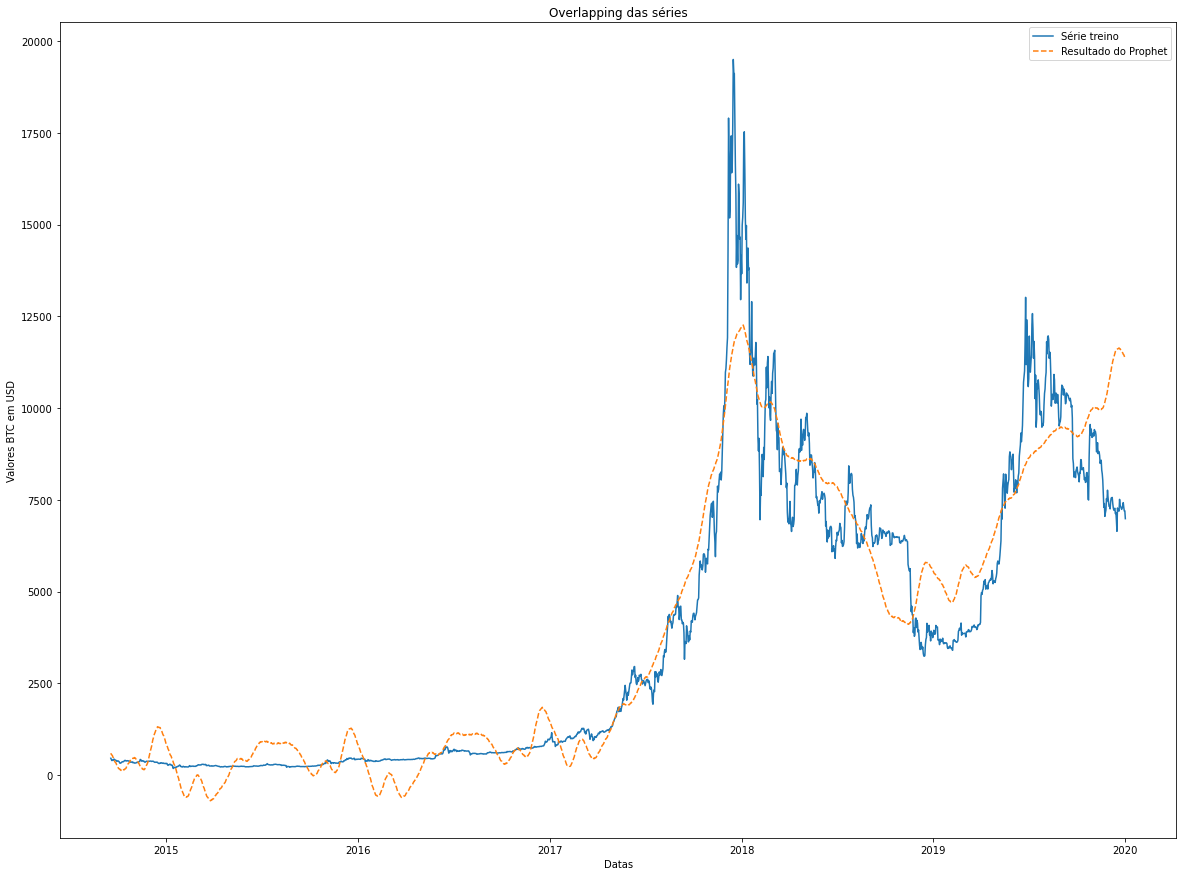

In [601]:
plt.figure(2, figsize=(20,15))
plt.title('Overlapping das séries')
plt.ylabel('Valores BTC em USD')
plt.xlabel('Datas')
plt.plot(dfpro['ds'],dfpro['y'], label='Série treino')
plt.plot(futuro['ds'],futuro['yhat'], linestyle='--', label='Resultado do Prophet')
plt.legend()
plt.savefig(f'Prophet')

In [602]:
df_cv = cross_validation(m, initial= '1883 days', horizon = '1 days', period='1 days')

INFO:prophet:Making 50 forecasts with cutoffs between 2019-11-13 00:00:00 and 2020-01-01 00:00:00


  0%|          | 0/50 [00:00<?, ?it/s]

In [603]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-11-14,9938.545055,8495.880313,11321.462037,8708.094727,2019-11-13
1,2019-11-15,9878.212929,8399.400189,11212.166773,8491.992188,2019-11-14
2,2019-11-16,9931.702416,8526.851197,11260.679395,8550.760742,2019-11-15
3,2019-11-17,9880.308937,8426.257082,11336.024328,8577.975586,2019-11-16
4,2019-11-18,9941.346787,8519.523819,11427.546123,8309.286133,2019-11-17
5,2019-11-19,9989.209105,8552.743143,11445.893297,8206.145508,2019-11-18
6,2019-11-20,9984.986372,8514.479313,11358.537290,8027.268066,2019-11-19
7,2019-11-21,9735.359605,8462.847886,11153.995166,7642.750000,2019-11-20
8,2019-11-22,9974.247039,8433.387446,11532.407560,7296.577637,2019-11-21
9,2019-11-23,10016.967383,8570.424217,11442.113278,7397.796875,2019-11-22


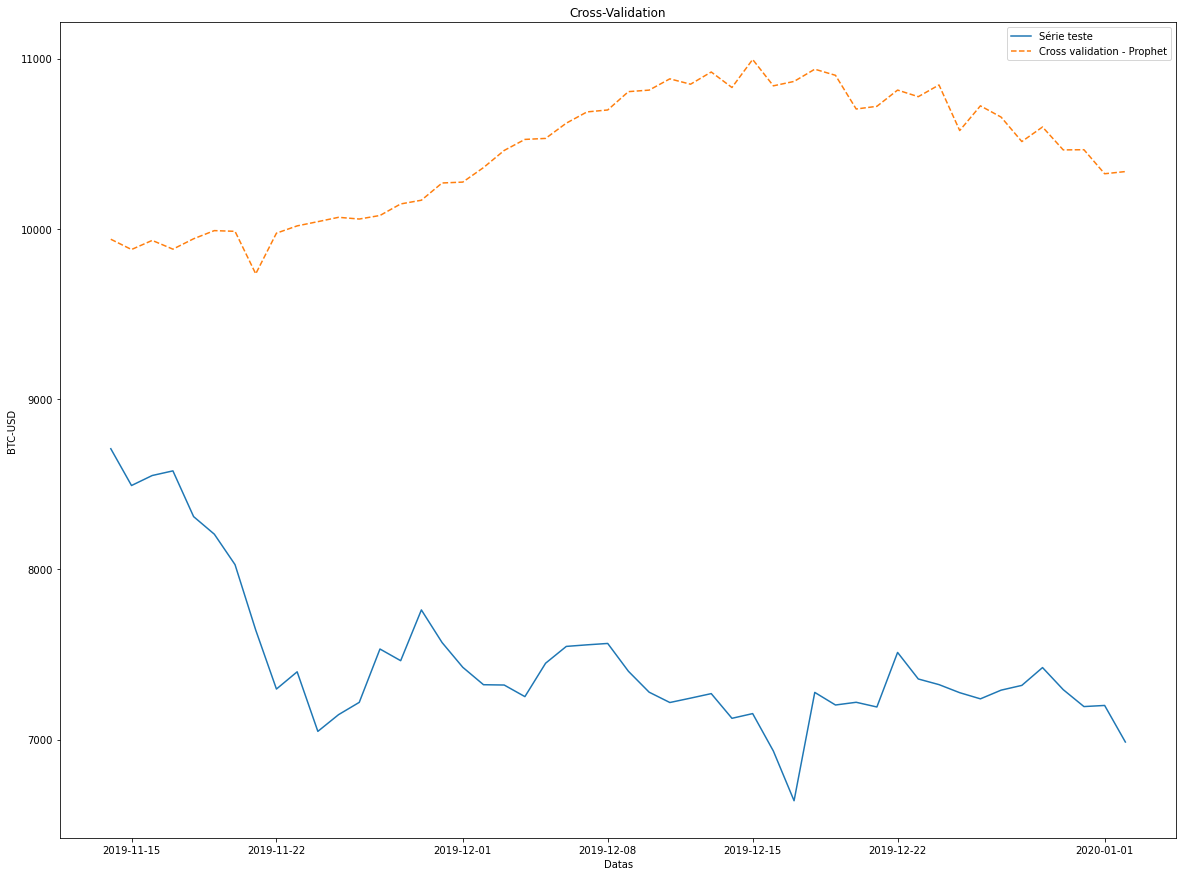

In [604]:
plt.figure(2, figsize=(20,15))
plt.title('Cross-Validation')
plt.ylabel('BTC-USD')
plt.xlabel('Datas')
plt.plot(teste, label='Série teste')
plt.plot(df_cv['ds'], df_cv['yhat'], label='Cross validation - Prophet', linestyle='--')
plt.legend()
plt.savefig('Cross-Validation')

In [651]:
erros = performance_metrics(df_cv, rolling_window=0.01)
round(erros[['rmse']],4)

,rmse
0,3073.8862


In [634]:
a = abs(df_cv['y'] - df_cv['yhat'])
a

0     1230.450329
1     1386.220742
2     1380.941674
3     1302.333351
4     1632.060654
5     1783.063597
6     1957.718305
7     2092.609605
8     2677.669402
9     2619.170508
10    2993.931969
11    2921.199563
12    2838.832103
13    2546.410641
14    2682.787300
15    2406.476939
16    2699.327689
17    2849.935333
18    3037.372599
19    3139.957147
20    3272.835121
21    3082.495627
22    3073.410426
23    3130.201648
24    3133.440752
25    3404.604575
26    3536.337204
27    3663.254507
28    3605.968817
29    3651.126343
30    3705.152652
31    3842.188057
32    3907.092239
33    4224.984698
34    3660.466724
35    3698.605360
36    3484.717775
37    3528.108495
38    3303.113840
39    3420.251032
40    3522.155881
41    3301.898733
42    3483.143911
43    3365.793340
44    3194.326709
45    3175.229044
46    3170.283149
47    3270.768849
48    3123.030890
49    3350.547520
dtype: float64

In [640]:
CV['Erro-Prophet'] = pd.DataFrame(index=CV.index, data=a)

In [641]:
CV

,Cross,Série,Erro,Erro-Prophet
2019-11-14,8786.901356,8708.094727,78.806629,NaN
2019-11-15,8733.350504,8491.992188,241.358316,NaN
2019-11-16,8448.004114,8550.760742,102.756628,NaN
2019-11-17,8584.729461,8577.975586,6.753875,NaN
2019-11-18,8554.012420,8309.286133,244.726288,NaN
2019-11-19,8308.625134,8206.145508,102.479627,NaN
2019-11-20,8204.080351,8027.268066,176.812285,NaN
2019-11-21,7998.521280,7642.750000,355.771280,NaN
2019-11-22,7649.945093,7296.577637,353.367456,NaN
2019-11-23,7251.277228,7397.796875,146.519647,NaN


In [608]:
test_var['y'][0:50].mean()

7458.735224609375

In [646]:
a.mean()

2989.2800673864963

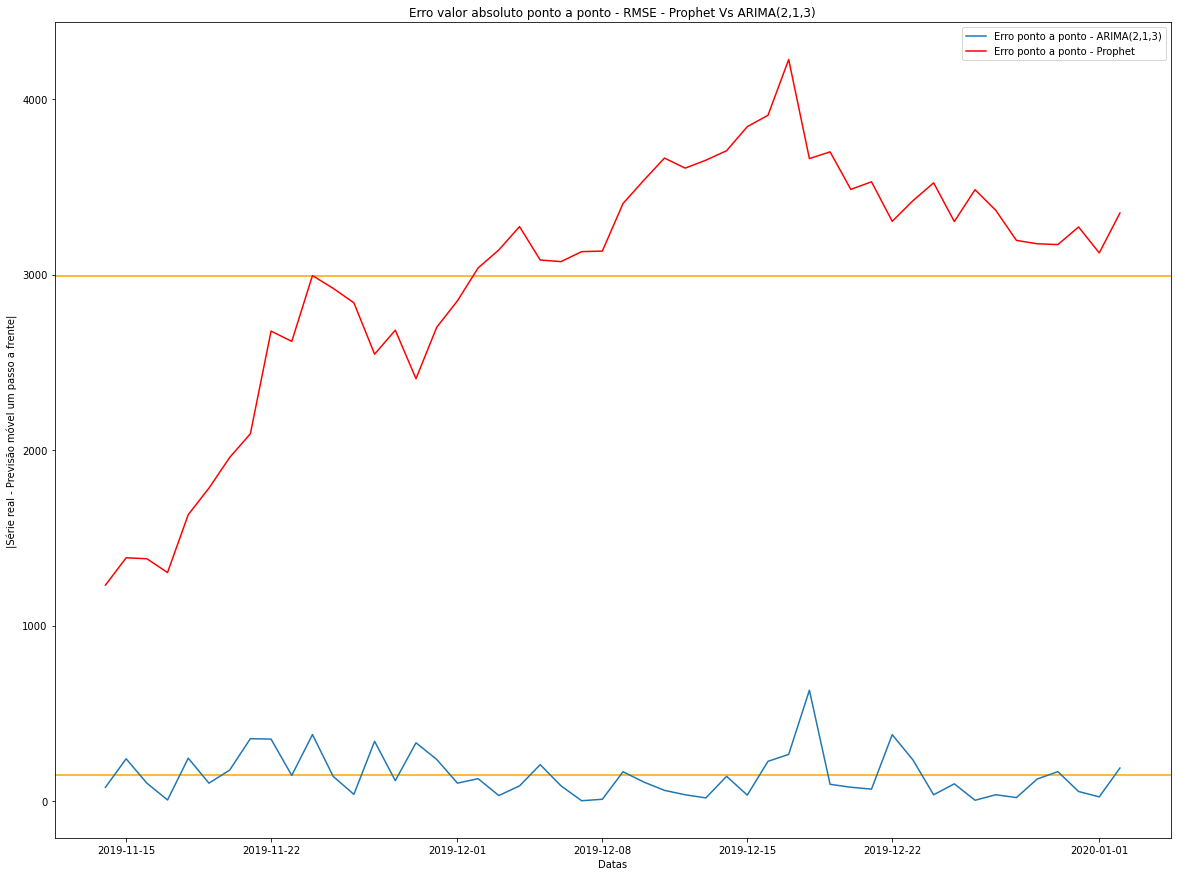

In [647]:
plt.figure(2, figsize=(20,15))
plt.title('Erro valor absoluto ponto a ponto - RMSE - Prophet Vs ARIMA(2,1,3)')
plt.ylabel('|Série real - Previsão móvel um passo a frente|')
plt.xlabel('Datas')
plt.axhline(a.mean(), color='orange')
plt.axhline(CV['Erro'].mean(), color='orange')
plt.plot(CV['Erro'], label='Erro ponto a ponto - ARIMA(2,1,3)')
plt.plot(df_cv['ds'],a, label='Erro ponto a ponto - Prophet', color='red')
plt.legend()
plt.savefig('Cross-Validation - ProphetvsARIMA')

Essa monografia possuia como objetivo a geração de um modelo confiável a partir 
de séries temporais para previsão do Bitcoin. 
A série possuia sazonalidade e para mantê-la de 
forma estática, foram feitas diferenciações da série penalizando-a pelo teste de Dickey-Fuller ampliado.
Com o modelo ARIMA(2,1,3) gerado e sua divisão 
entre série de treino e teste, com penalidades em erro médio 
quadrático comparando ao modelo gerado pelo Prophet do Facebook 
determinamos o modelo com menores erros residuais foi a série ARIMA(2,1,3), 
sendo portanto, mais eficaz para a previsão do Bitcoin.